In [1]:
!pip install emoji transformers

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter, defaultdict
import emoji
from collections import Counter
from tqdm.notebook import tqdm
from textwrap import wrap
import random
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("/kaggle/input/emotion-detection-from-text/tweet_emotions.csv")
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [6]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

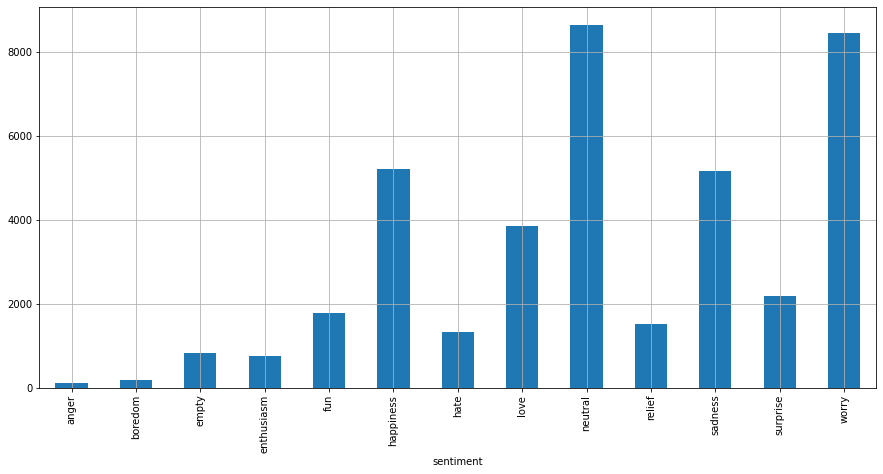

In [7]:
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

In [8]:
from sklearn.utils import resample

sent = df.sentiment.unique()

max = 3
target_majority = df[df.sentiment==sent[max]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = df[df.sentiment==sent[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 
#'''

anger         8638
relief        8638
boredom       8638
happiness     8638
hate          8638
fun           8638
love          8638
surprise      8638
worry         8638
enthusiasm    8638
sadness       8638
empty         8638
neutral       8638
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

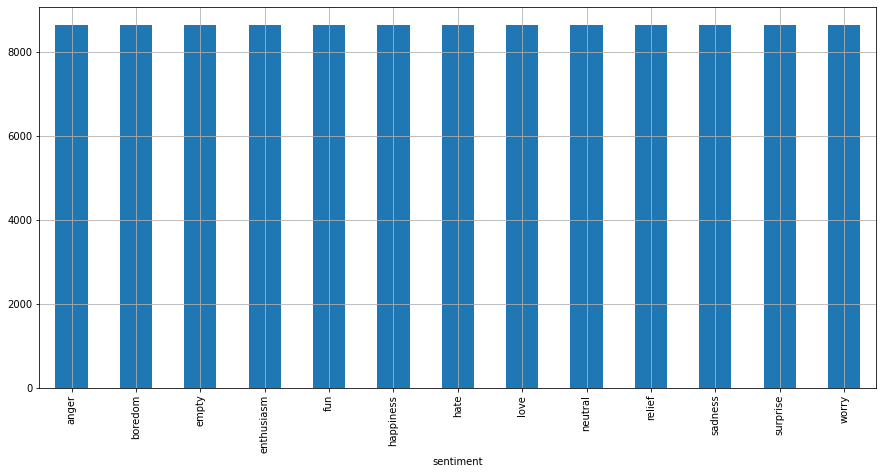

In [9]:
df = train_upsampled.sample(frac=1).reset_index(drop=True)
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)


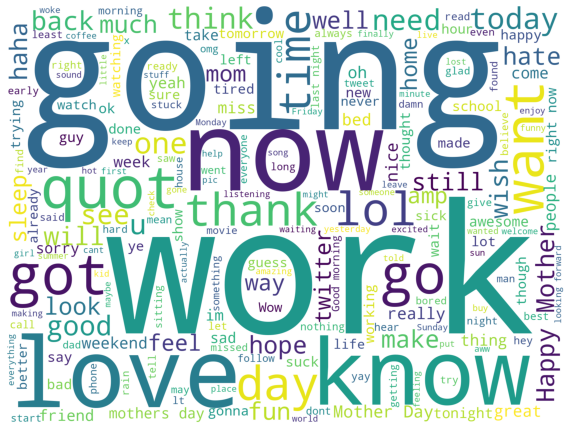

In [10]:
df_cloud = df[df['sentiment']=='neutral'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

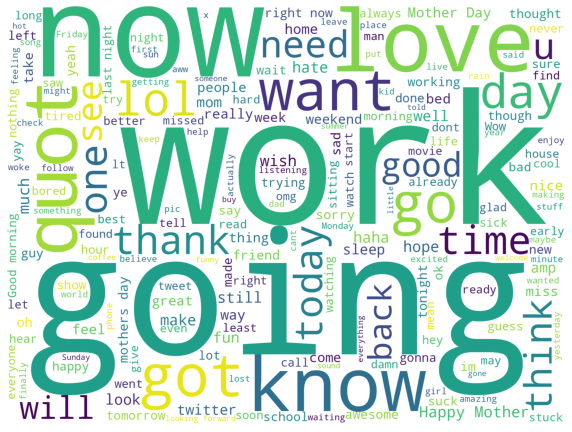

In [11]:
df_cloud = df[df['sentiment']=='happiness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

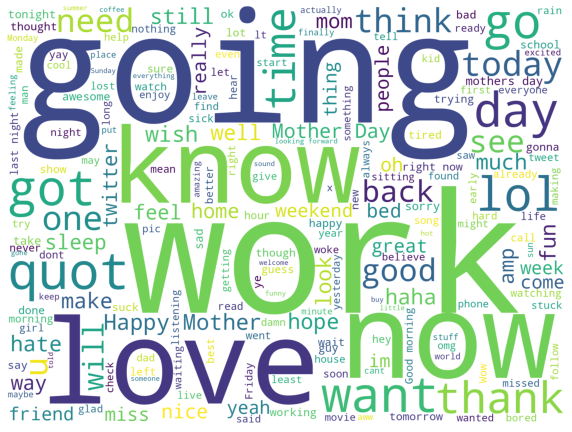

In [12]:
df_cloud = df[df['sentiment']=='worry'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

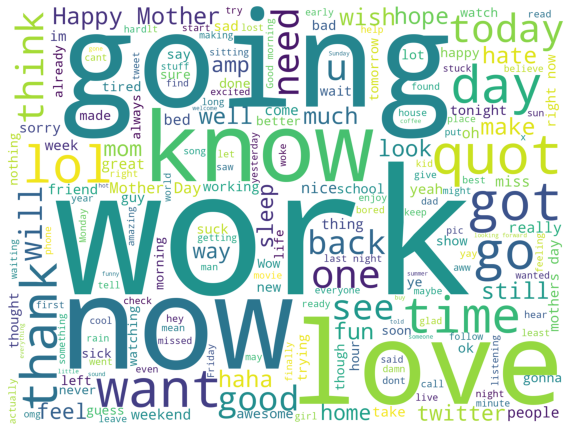

In [13]:
df_cloud = df[df['sentiment']=='sadness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)

In [15]:
sent

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [16]:
label

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [17]:
df['label'] = df.sentiment.replace(label)
df.head()


,tweet_id,sentiment,content,label
0,1694364337,neutral,Grey's 'Sweet Surrender' http://tinyurl.com/d...,3
1,1966280593,worry,@ahewitt Me too,4
2,1753664326,neutral,Looking for new picture for my twitter backgro...,3
3,1753483523,neutral,At Twin Peaks. High Yay!,3
4,1694345940,neutral,@brandiheyy hey !!! whoa its really you.. any...,3


In [18]:
from operator import itemgetter  

d = df.label.value_counts()
for key, value in sorted(d.items(), key = itemgetter(0), reverse = False):
    print(key, value)


0 8638
1 8638
2 8638
3 8638
4 8638
5 8638
6 8638
7 8638
8 8638
9 8638
10 8638
11 8638
12 8638


In [19]:
english_stopwords = set(stopwords.words("english"))
english_punctuations = string.punctuation

def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in english_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line = line.lower()
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')

    
    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in english_punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', english_punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [20]:
df.content = df.content.apply(cleaning_content)

In [21]:
df

,tweet_id,sentiment,content,label
0,1694364337,neutral,grey sweet surrender,3
1,1966280593,worry,,4
2,1753664326,neutral,looking new picture twitter help little,3
3,1753483523,neutral,twin peaks high yay,3
4,1694345940,neutral,hey whoa really anyways feel living miley must...,3
...,...,...,...,...
112289,1751785869,surprise,tell obvious real life makes great entertainme...,5
112290,1958093165,surprise,trivia working computer,5
112291,1694667923,neutral,wow joined photography scene pretty recently l...,3
112292,1957083641,anger,fuckin transtelecom,12


In [22]:
df.drop('tweet_id', inplace=True, axis=1)


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
df

,sentiment,content,label
0,neutral,grey sweet surrender,3
1,worry,,4
2,neutral,looking new picture twitter help little,3
3,neutral,twin peaks high yay,3
4,neutral,hey whoa really anyways feel living miley must...,3
...,...,...,...
112289,surprise,tell obvious real life makes great entertainme...,5
112290,surprise,trivia working computer,5
112291,neutral,wow joined photography scene pretty recently l...,3
112292,anger,fuckin transtelecom,12


In [25]:
content = ' '.join(list(df.content))
words = content.split(' ')

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.content)
corpus[:10]


['grey',
 'sweet',
 'surrender',
 'looking',
 'new',
 'picture',
 'twitter',
 'help',
 'little',
 'twin']

In [27]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'day': 8183,
 'good': 6113,
 'get': 5747,
 'like': 5581,
 'go': 5263,
 'work': 5097,
 'going': 4551,
 'got': 4509,
 'today': 4479,
 'im': 4374}

<AxesSubplot:xlabel='sentiment'>

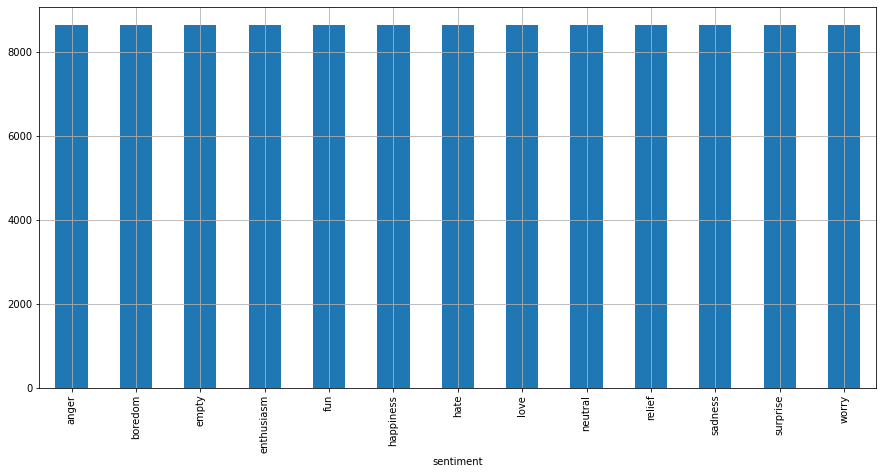

In [28]:
df.groupby('sentiment')['content'].count().plot.bar(figsize=(15,7),grid=True)

In [29]:
max_len = 100

In [30]:
class SentiDataset(Dataset):
    def __init__(self, contents, labels, tokenizer, max_len):
        self.contents = contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.contents)
  
    def __getitem__(self, item):
        content = str(self.contents[item])
        label = self.labels[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          content,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'content': content,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [31]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=random.seed(42))
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=random.seed(42))

print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 80851
size of validation set : 8984
size of test set : 22459


In [32]:
df['data_type'] = ['not_set']*df.shape[0]


In [33]:
df

,sentiment,content,label,data_type
0,neutral,grey sweet surrender,3,not_set
1,worry,,4,not_set
2,neutral,looking new picture twitter help little,3,not_set
3,neutral,twin peaks high yay,3,not_set
4,neutral,hey whoa really anyways feel living miley must...,3,not_set
...,...,...,...,...
112289,surprise,tell obvious real life makes great entertainme...,5,not_set
112290,surprise,trivia working computer,5,not_set
112291,neutral,wow joined photography scene pretty recently l...,3,not_set
112292,anger,fuckin transtelecom,12,not_set


In [34]:
df.loc[df_train.index.to_numpy(), 'data_type'] = 'train'
df.loc[df_val.index.to_numpy(), 'data_type'] = 'val'
df.loc[df_test.index.to_numpy(), 'data_type'] = 'test'

In [35]:
df

,sentiment,content,label,data_type
0,neutral,grey sweet surrender,3,test
1,worry,,4,train
2,neutral,looking new picture twitter help little,3,test
3,neutral,twin peaks high yay,3,test
4,neutral,hey whoa really anyways feel living miley must...,3,val
...,...,...,...,...
112289,surprise,tell obvious real life makes great entertainme...,5,test
112290,surprise,trivia working computer,5,train
112291,neutral,wow joined photography scene pretty recently l...,3,train
112292,anger,fuckin transtelecom,12,val


In [36]:
df.groupby(['sentiment', 'label', 'data_type']).count()

content
sentiment  label data_type         
anger      12    test          1718
                 train         6256
                 val            664
boredom    10    test          1718
                 train         6238
                 val            682
empty      0     test          1669
                 train         6275
                 val            694
enthusiasm 2     test          1731
                 train         6234
                 val            673
fun        7     test          1764
                 train         6164
                 val            710
happiness  9     test          1693
                 train         6260
                 val            685
hate       8     test          1781
                 train         6182
                 val            675
love       6     test          1726
                 train         6232
                 val            680
neutral    3     test          1752
                 train         6202
                 val            684
relief     11    test          1735
                 train         6187
                 val            716
sadness    1     test          1751
                 train         6179
                 val            708
surprise   5     test          1676
                 train         6266
                 val            696
worry      4     test          1745
                 train         6176
                 val            717

In [37]:
def generate_dataloader(df, tokenizer, max_len, batch_size):
    ds = SentiDataset(
        contents=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [38]:
batch_size = 16
train_dataloader = generate_dataloader(df_train, tokenizer, max_len ,batch_size)
val_dataloader = generate_dataloader(df_val, tokenizer, max_len ,batch_size)
test_dataloader = generate_dataloader(df_test, tokenizer, max_len ,batch_size)

data = next(iter(train_dataloader))
print(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

{'content': ['internet painfully slow today', 'trent get mad keep thinking pretending engaged reason', '', 'shout moms wakin prematurely preciate', 'welcome much longer colored', 'headed home see yall tweets', 'kickass day full seaworld retarded 15 year old guys x men origins win day', 'funny discussed bela lugosi dinner apearance plan b outer space best movie ever', 'safely say euro winner week', 'nooooo something immediately leaving 2 weeks', 'mimi time', 'phone whatchu tonight sucka dane cook sold tickets lamee', 'oh yes quite really retire g night doll nice chattin ya', 'two dozen roses sent overnight delivered morning found recipient town sad', 'mere fact twittered someone read matters p love song gravity', 'finished work nd waiting freezing cold drinking mango magic haha fail mama wheree yu cold'], 'input_ids': tensor([[  101,  4274, 16267,  ...,     0,     0,     0],
        [  101,  7990,  2131,  ...,     0,     0,     0],
        [  101,   102,     0,  ...,     0,     0,     0

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)


torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [40]:
bert = BertModel.from_pretrained("bert-base-uncased")


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [41]:
model_outs = bert(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

pooled_output = model_outs[1]
last_hidden_state = model_outs[0]

In [42]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Adding drop out, keeping 90% of the last neurons of the raw BERT model
        self.drop = nn.Dropout(p=0.1)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:
model = SentimentClassifier(len(sent))

# Running the classifier on GPU
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [45]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1358, 0.1153, 0.0530, 0.0767, 0.0992, 0.0548, 0.0748, 0.0894, 0.0486,
         0.0589, 0.0586, 0.0511, 0.0839],
        [0.1096, 0.1120, 0.0462, 0.0687, 0.1057, 0.0524, 0.0806, 0.1091, 0.0629,
         0.0695, 0.0391, 0.0689, 0.0753],
        [0.1050, 0.1310, 0.0515, 0.0959, 0.0635, 0.0501, 0.0702, 0.0986, 0.0547,
         0.0733, 0.0693, 0.0598, 0.0774],
        [0.1246, 0.1151, 0.0361, 0.0761, 0.0736, 0.0545, 0.0880, 0.0795, 0.0461,
         0.0690, 0.0608, 0.0649, 0.1116],
        [0.1265, 0.1068, 0.0558, 0.0703, 0.0996, 0.0628, 0.0842, 0.0766, 0.0532,
         0.0626, 0.0433, 0.0718, 0.0867],
        [0.1259, 0.1421, 0.0441, 0.0764, 0.0863, 0.0428, 0.0788, 0.0831, 0.0501,
         0.0513, 0.0672, 0.0601, 0.0919],
        [0.0739, 0.1498, 0.0368, 0.0784, 0.0777, 0.0527, 0.0679, 0.0578, 0.0518,
         0.0635, 0.0886, 0.0678, 0.1333],
        [0.0871, 0.1305, 0.0343, 0.0833, 0.0864, 0.0461, 0.0788, 0.0751, 0.0562,
         0.0639, 0.0784, 0.0710, 0.1090],
        [0.1466,

In [46]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  correct_bias=False)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

In [47]:
loss_fn = nn.CrossEntropyLoss().to(device)


In [48]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la, preds, average='weighted'))

In [49]:
def train(model, train_dataloader,optimizer,scheduler):

        # Reset tracking variables at the beginning of each epoch
        precision, correct_predictions, batch_counts = 0, 0, 0
        losses = []

        # Put the model into the training mode
        model.train()

  
        # For each batch of training data...
        for d in train_dataloader:
              batch_counts +=1
              # Load batch to GPU
              input_ids = d["input_ids"].to(device)
              attention_mask = d["attention_mask"].to(device)
              labels = d["labels"].to(device)

              outputs = model(input_ids=input_ids,attention_mask=attention_mask)
              
              _, preds = torch.max(outputs, dim=1)
              
              # Compute loss and accumulate the loss values

              loss = loss_fn(outputs, labels)

              correct_predictions += torch.sum(preds == labels)
              losses.append(loss.item())
              precision +=  compute_precision(outputs, labels)
            
              loss.backward()

              # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              # Update parameters and the learning rate  
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
          # Accuracy, loss, precision
        return correct_predictions.double() / len(df_train), np.mean(losses), precision/batch_counts

In [50]:
def eval(model, valid_dataloader, loss_fn, device, n):
    model = model.eval()


    correct_predictions , precision ,batch_counts = 0,0,0
    losses = []

    with torch.no_grad():
        for d in valid_dataloader:
            batch_counts += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, labels)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == labels)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,labels)

            losses.append(loss.item())
    # Accuracy, loss, precision 
    return correct_predictions.double()/n, np.mean(losses), precision/batch_counts 

In [51]:
!nvidia-smi

Sun Dec  5 21:32:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   2559MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
history = defaultdict(list)
b_accuracy = 0

for epoch in range(epochs):
  
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 20)

  train_acc, train_loss, train_preci = train(
        model,
        train_dataloader,    
        optimizer, 
        scheduler,
      )
  print(f"Train : Loss {train_loss}, Accuracy : {train_acc*100:.2f} %, Precision : {train_preci}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_precision'].append(train_preci)

  val_acc, val_loss, val_preci = eval(
        model,
        val_dataloader,
        loss_fn, 
        device,
        len(df_val),
      )

  print(f'Val : Loss :{val_loss}, Accuracy : {val_acc*100:.2f} %, Precision : {val_preci}')  
  print()

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_precision'].append(val_preci)
  
  if val_acc > b_accuracy:
    torch.save(model.state_dict(), 'best_model.bin')
    b_accuracy = val_acc

Epoch 1/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 1.4705197765898412, Accuracy : 50.97 %, Precision : 0.5410601506957754


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.9364837700255825, Accuracy : 68.88 %, Precision : 0.7063312891882728

Epoch 2/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.738180194922797, Accuracy : 75.47 %, Precision : 0.7909380820079775


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.6558149503245685, Accuracy : 78.94 %, Precision : 0.8121372436875092

Epoch 3/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.4536603592831139, Accuracy : 85.24 %, Precision : 0.8807674731942712


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5686473685086396, Accuracy : 83.03 %, Precision : 0.8522575622775792

Epoch 4/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.3179806268296334, Accuracy : 89.76 %, Precision : 0.9189014005879402


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5710624256656005, Accuracy : 84.05 %, Precision : 0.8593509045077095



In [53]:
b_accuracy

tensor(0.8405, device='cuda:0', dtype=torch.float64)

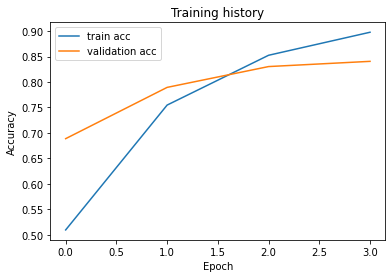

In [54]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


In [55]:
model.load_state_dict(torch.load('best_model.bin'))
test_acc,test_loss, _ = eval(model, test_dataloader, loss_fn,device, len(df_test))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.575 | Test Acc: 84.12%


In [56]:
def predict_sentiment(model, dataloader):
  model = model.eval()
  
  contents = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in dataloader:

      texts = d["content"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      contents.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return contents, predictions, prediction_probs, real_values



In [57]:
y_contents, y_pred, y_pred_probs, y_test = predict_sentiment(
  model,
  test_dataloader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [58]:
print(classification_report(y_test, y_pred, target_names=sent))

              precision    recall  f1-score   support

       empty       0.90      0.98      0.94      1669
     sadness       0.72      0.74      0.73      1751
  enthusiasm       0.96      0.99      0.97      1731
     neutral       0.54      0.40      0.46      1752
       worry       0.65      0.56      0.60      1745
    surprise       0.86      0.89      0.88      1676
        love       0.78      0.81      0.79      1726
         fun       0.88      0.93      0.90      1764
        hate       0.95      0.98      0.96      1781
   happiness       0.69      0.72      0.70      1693
     boredom       0.99      1.00      1.00      1718
      relief       0.91      0.96      0.93      1735
       anger       1.00      1.00      1.00      1718

    accuracy                           0.84     22459
   macro avg       0.83      0.84      0.84     22459
weighted avg       0.83      0.84      0.84     22459



In [59]:
df_test1 = pd.read_csv("/kaggle/input/testset/climate-pp.csv")
df_test2 = pd.read_csv("/kaggle/input/testset/meta_nc.csv")

In [60]:
df_test1

,DocText,DocDate
0,400 private jets too the climate change summit...,2021-11-02 23:23:58
1,“Covid” restrictions are so much like “Climate...,2021-11-02 23:22:22
2,Thank you to everybody who made this a success...,2021-11-02 23:09:11
3,anti-climate change **** deserve love and respect,2021-11-02 22:27:22
4,Very alarming ang effects ng climate change es...,2021-11-02 22:26:23
...,...,...
361,Always love @amelia_draper on @nbcwashington p...,2021-03-16 22:42:09
362,Thank you @NYSenDems for including the $3 bill...,2021-03-16 22:20:31
363,"Thank you so much @Kevin_Fong @astro_timpeake,...",2021-03-16 20:55:31
364,Always love seeing representatives of actual p...,2021-03-15 23:46:38


In [61]:
df_test2

,DocText,DocDate
0,Facebook doesn’t have a great rep when it come...,2021-10-28 23:59:52
1,Wasn’t Meta a superhero in one of the Pixar mo...,2021-10-28 23:59:51
2,Not that it will lead anywhere but the idea be...,2021-10-28 23:59:27
3,Zuckerburg changing FB to Meta just confirms w...,2021-10-28 23:59:23
4,Everytime i open twitter now i see a headline ...,2021-10-28 23:58:55
...,...,...
2642,bad team? oh no its just anti meta you wouldnt...,2021-10-27 00:46:13
2643,no one is a must pull in this game not zhongli...,2021-10-27 00:29:15
2644,Isn't drawing a tree on paper actually meta ?,2021-10-27 00:20:24
2645,"""isn't that awesome"" -dad's gf referring to ho...",2021-10-27 00:07:42


In [62]:
df_test = pd.concat([df_test1, df_test2], ignore_index=True)
df_test.drop('DocDate', inplace=True, axis=1)
df_test = df_test.rename(columns={'DocText': 'content'})
df_test['label'] = ''
df_test.content = df_test.content.apply(cleaning_content)
df_test

,content,label
0,400 private jets climate change summit amazing,
1,“covid” restrictions much like “climate change...,
2,thank everybody made successful bookbirthday a...,
3,anti climate change deserve love respect,
4,alarming ang effects ng climate change especia...,
...,...,...
3008,bad team oh anti meta wouldnt get,
3009,one must pull game zhongli ganyu whomstever cl...,
3010,drawing tree paper actually meta,
3011,awesome dad gf referring judge acknowledge two...,


In [63]:
L = []
for review_text in df_test.content:
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    L.append(sent[prediction])
df_test.label = L
df_test

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,content,label
0,400 private jets climate change summit amazing,happiness
1,“covid” restrictions much like “climate change...,worry
2,thank everybody made successful bookbirthday a...,happiness
3,anti climate change deserve love respect,love
4,alarming ang effects ng climate change especia...,worry
...,...,...
3008,bad team oh anti meta wouldnt get,worry
3009,one must pull game zhongli ganyu whomstever cl...,worry
3010,drawing tree paper actually meta,surprise
3011,awesome dad gf referring judge acknowledge two...,love
